In [ ]:
# Installing missing libraries
!pip install datasets
!pip install gensim
!pip install seqeval
!pip install torch

In [1]:
import pandas as pd
import numpy as np
import os
import gensim
import gensim.downloader as api
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors
from datasets import load_dataset
from collections import Counter
from itertools import product

In [2]:
# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset Preparation (derivations from Part 1)


In [4]:
# Function to preprocess the text
def preprocess_text(text):
    return simple_preprocess(text, deacc=True)  # deacc = True -> remove accent marks e.g. café to cafe

# Preprocess the training dataset
train_tokens = [preprocess_text(example['text']) for example in train_dataset]

# Iterate through the train dataset tokens and get the unique words to build vocabulary
vocab_counter = Counter([word for tokens in train_tokens for word in tokens])
train_vocab = list(vocab_counter.keys())

# File Path to directory to store the pre-defined models (change as necessary)
model_dir_path = "models"

# Load the Wiki FastText vectors from the .vec file (will take a few minutes to run)
wiki_fasttext_model = KeyedVectors.load_word2vec_format(os.path.join(model_dir_path, "wiki.en.vec"), binary=False)

## Creating the Embedding Matrix from the FastText pretrained vectors

We will now create the embedding matrix using the FastText pretrained vectors and for the remaining 240 OOV words (from part 1), we will take initialise the vectors using the normalised values from the vocabulary.

We want to keep the random embeddings close to zero, ensuring less variance in OOV word representation. Hence, we will assign the scale to have a value of ```0.2```

In [ ]:
embedding_dim = wiki_fasttext_model.vector_size  # Get the FastText embedding dimension

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((len(train_vocab), embedding_dim))

# Fill the embedding matrix
for idx, word in enumerate(train_vocab):
    if word in wiki_fasttext_model:
        # Use FastText embedding
        embedding_matrix[idx] = wiki_fasttext_model[word]  
    else:
        # Random initialisation for out-of-vocabulary (OOV) words
        embedding_matrix[idx] = np.random.normal(scale=0.2, size=(embedding_dim,))

# Print shape of the embedding matrix for debugging
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (16256, 300)


## Define the SentimentDataset Class and Collate Function

In [6]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert each token in the sentence to its corresponding index, 0 for unknown words
        tokens = self.texts[idx].split()
        embedding_indices = [self.vocab.get(word, 0) for word in tokens]
        label = self.labels[idx]

        # Skip any sequences that are effectively empty
        if len(embedding_indices) == 0 or all(index == 0 for index in embedding_indices):
            return None
        return torch.tensor(embedding_indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)


def collate_fn(batch):
    # Filter out None values
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None, None

    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=0)  # Pad sequences with 0
    labels = torch.stack(labels)
    return texts, labels

## Prepare datasets for dataloader

In [7]:
# Replace these with actual dataset texts and labels
train_texts = train_dataset['text']
train_labels = train_dataset['label']
val_texts = validation_dataset['text']
val_labels = validation_dataset['label']
test_texts = test_dataset['text']
test_labels = test_dataset['label']

# Create vocabulary to index mapping (from Part 1)
vocab_to_index = {word: idx for idx, word in enumerate(train_vocab)}

# Instantiate datasets
train_data = SentimentDataset(train_texts, train_labels, vocab_to_index)
val_data = SentimentDataset(val_texts, val_labels, vocab_to_index)
test_data = SentimentDataset(test_texts, test_labels, vocab_to_index)

## RNN Model

### Define RNN Model

In this question, we will unfreeze the embedding matrix of the pre-trained vectors of the FastText and analyse the difference in the accuracy scores including part 2 and 3.1 for our best model, ```Last Hidden Layer RNN```

In [8]:
class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, pooling_strategy, dropout=0.5):
        super(SentimentRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False) # Set freeze=False to let word embeddings to be updated
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.pooling_strategy = pooling_strategy

    def forward(self, text):
        lengths = (text != 0).sum(dim=1)
        lengths, perm_idx = lengths.sort(0, descending=True)
        text = text[perm_idx]

        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=True)

        packed_output, hidden = self.rnn(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Apply the selected pooling strategy
        if self.pooling_strategy == 'last':
            hidden = hidden.squeeze(0)
            sentence_representation = hidden[perm_idx.argsort()]
        elif self.pooling_strategy == 'max':
            sentence_representation, _ = torch.max(output, dim=1)
        elif self.pooling_strategy == 'mean':
            sentence_representation = torch.mean(output, dim=1)
        elif self.pooling_strategy == 'max + mean':
            max_pooled, _ = torch.max(output, dim=1)
            mean_pooled = torch.mean(output, dim=1)
            sentence_representation = (max_pooled + mean_pooled) / 2

        # Pass through the fully connected layer
        sentence_representation = self.dropout(sentence_representation)
        return self.fc(sentence_representation)

## Training and Evaluation Helper Functions

In [9]:
# Function to save model
def save_model(model, model_save_path):
    try:
        # Save the model directly (it overwrites the file if it exists)
        torch.save(model.state_dict(), model_save_path)
        print("Model saved.")
    except Exception as e:
        print(f"Failed to save model to {model_save_path}: {e}")

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    for texts, labels in loader:
        # Skip empty batches
        if texts is None or labels is None:
            continue
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), total_correct / len(loader.dataset)

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for texts, labels in loader:
          # Skip empty batches
          if texts is None or labels is None:
              continue
          outputs = model(texts)
          loss = criterion(outputs, labels)
          total_loss += loss.item()
          total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), total_correct / len(loader.dataset)

# Function for the whole model training and evaluation process
def train_and_evaluate(
    model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=100,
    early_stopping_patience=10,
    pooling_strategy=None,
    load_best_model=False
):
    print(f"Training with pooling strategy: {pooling_strategy}")

    # Ensure the model uses the correct pooling strategy
    model.pooling_strategy = pooling_strategy

    best_val_accuracy = 0
    no_improve_epochs = 0

    # Initialising Data Structures
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Train the model within specified number of epochs
    for epoch in range(epochs):

        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        # Append values to list
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch metrics
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping logic
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improve_epochs = 0
            save_model(model, os.path.join(os.getcwd(), f'best_model_{pooling_strategy}.pt'))
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs.")
            if no_improve_epochs >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1} due to no improvement.")
                break
    
    # Load the best model
    if load_best_model:
        path = os.path.join(os.getcwd(), f'best_model_{pooling_strategy}.pt')
        with open(path, 'rb') as f:
            model.load_state_dict(torch.load(f))
        print("Best Model Loaded.")

    return train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies

In [10]:
# Function to create the plots for analysis
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker = 'o', color = 'blue')
    plt.plot(epochs, test_losses, label='Test Loss', marker = 'o', color = 'green')
    plt.plot(epochs, val_losses, label='Validation Loss', marker = 'o', color = 'red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker = 'o', color = 'blue')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', marker = 'o', color = 'green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker = 'o', color = 'red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Initialize parameters and prepare DataLoaders

In [11]:
# Adjusted hyperparameters based on Part 2
batch_size = 32
hidden_dim = 128  # Reduced hidden dimension
output_dim = 2    # Binary classification (positive/negative sentiment)
learning_rate = 0.001
weight_decay = 1e-4
epochs = 100

In [12]:
# Data loaders with collate function
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)

## Best RNN Model (Last Hidden Layer)


### Instantiate Model, Optimiser, and Loss Function

In [54]:
# Initialising RNN Model (last hidden layer) and model's parameters
pooling_strategy = 'last'
model = SentimentRNN(embedding_matrix, hidden_dim, output_dim, pooling_strategy)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [55]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    early_stopping_patience=5,
    pooling_strategy=pooling_strategy,
    load_best_model=True)

Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.6237, Train Accuracy: 0.6518
Test Loss: 0.5521, Test Accuracy: 0.7242
Val Loss: 0.5805, Val Accuracy: 0.7045
Model saved.

Epoch 2/100
Train Loss: 0.4760, Train Accuracy: 0.7865
Test Loss: 0.5627, Test Accuracy: 0.7261
Val Loss: 0.5913, Val Accuracy: 0.7083
Model saved.

Epoch 3/100
Train Loss: 0.3438, Train Accuracy: 0.8576
Test Loss: 0.6212, Test Accuracy: 0.7261
Val Loss: 0.6768, Val Accuracy: 0.6895
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.2305, Train Accuracy: 0.9100
Test Loss: 0.8439, Test Accuracy: 0.7280
Val Loss: 0.9140, Val Accuracy: 0.7026
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.1647, Train Accuracy: 0.9370
Test Loss: 0.8690, Test Accuracy: 0.6886
Val Loss: 0.8835, Val Accuracy: 0.6829
No improvement for 3 epochs.

Epoch 6/100
Train Loss: 0.1187, Train Accuracy: 0.9536
Test Loss: 1.0810, Test Accuracy: 0.6970
Val Loss: 1.2040, Val Accuracy: 0.6792
No improvement for 4 epochs.

Epoc

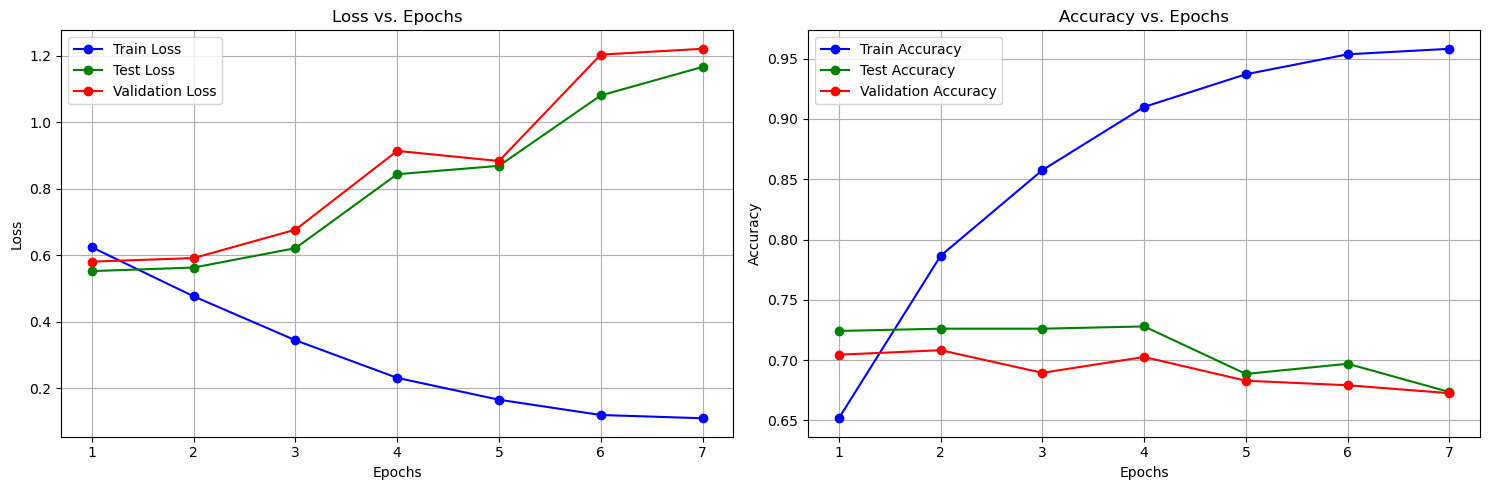

In [56]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [57]:
# Final evaluation on the validation set to compare whether model is correct
last_val_loss, last_val_accuracy = evaluate(model, val_loader, criterion)
print(f"Validation Loss: {last_val_loss:.4f}, Validation Accuracy: {last_val_accuracy:.4f}")

Validation Loss: 0.5913, Validation Accuracy: 0.7083


In [58]:
# Final evaluation on the test set
last_test_loss, last_test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {last_test_loss:.4f}, Test Accuracy: {last_test_accuracy:.4f}")

Test Loss: 0.5627, Test Accuracy: 0.7261


# Answers to Question 3(b)

### 3(b): Report the accuracy score on the test set when applying your method to deal with OOV words

In [64]:
print(f"RNN Last State - Validation Accuracy: {last_val_accuracy:.4f}, Test Accuracy: {last_test_accuracy:.4f}")

RNN Last State - Validation Accuracy: 0.7083, Test Accuracy: 0.7261


| Method              | Test Accuracy in Part 2 | Test Accuracy in Part 3.1 | Test Accuracy in Part 3.2 |
|---------------------|-----------------------|-------------------------|-------------------------|
| RNN Last State      | 0.6135               | 0.7167               | 0.7261 |

Based on the Test Accuracy in Part 3.2, we can evidently conclude that the OOV mitigation method in Part 1 has increased the accuracy of the model.